In [ ]:
# !pip install networkx 
!conda install -c dglteam dgl-cuda10.1 -y

# used for distance calculation between cities
!pip install geopy  

# used for visualizing the graphs
!pip install graphviz
!pip install cgraph
!conda install python-graphviz -y
!pip install pygraphviz


In [11]:
# get data from here - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
from geopy.distance import vincenty
import geopy
import requests
import urllib
import os.path as osp
import torch
import torch.nn.functional as F
import itertools
from dgl.nn.pytorch import GraphConv

from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt


import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph


# read data, take only data for USA at the most recent date (day)
df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
df = df[df['Country']=="United States"]
df = df[df['dt']=="2013-09-01"]
df = df.fillna(0)

df = df.head(100)  # used for testing...
df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
49879,2013-09-01,25.791,1.180,Abilene,United States,32.95N,100.53W
140304,2013-09-01,17.799,1.093,Akron,United States,40.99N,80.95W
170399,2013-09-01,19.207,0.866,Albuquerque,United States,34.56N,107.03W
190766,2013-09-01,19.643,1.050,Alexandria,United States,39.38N,76.99W
205489,2013-09-01,17.408,1.048,Allentown,United States,40.99N,74.56W


In [14]:
# Add elevation for each lat-long - takes ~1sec per coordinate
# USGS Elevation Point Query Service - needs a different format of points, so casted by geopy
url = r'https://nationalmap.gov/epqs/pqs.php?'


def elevation_function(df):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df["Latitude"], df["Longitude"]):

        pos = geopy.Point.from_string(lat + " " + lon)
        # query params
        params = {
            'output': 'json',
            'x': pos.longitude, 
            'y': pos.latitude, 
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

elevation_function(df)
df = df[df['elev_meters'] != '-1000000']  # remove nodes with faulty values
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,elev_meters
49879,2013-09-01,25.791,1.180,Abilene,United States,32.95N,100.53W,631.85
140304,2013-09-01,17.799,1.093,Akron,United States,40.99N,80.95W,331.81
170399,2013-09-01,19.207,0.866,Albuquerque,United States,34.56N,107.03W,1595.53
190766,2013-09-01,19.643,1.050,Alexandria,United States,39.38N,76.99W,187.18
205489,2013-09-01,17.408,1.048,Allentown,United States,40.99N,74.56W,327.85


In [15]:
print([e for e in df['elev_meters']])

[631.85, 331.81, 1595.53, 187.18, 327.85, 844.1, 77.21, 185.73, 348.81, 189.76, 187.18, 3911.3, 428.37, 1757.06, 207.47, 151.49, 83.13, 187.18, 0.4, 1.52, 175.56, 348.81, 107.14, 330.57, 0, 520.05, 701.61, 330.57, 0, 189.76, 203.02, 323.03, 378.27, 0, 108.58, 317.08, 175.9, 303.04, 191.33, 0.35, 331.81, 1757.06, 108.58, 200.07, 284.74, 348.81, 2.46, 9.4, 189.76, 284.74, 189.76, 1757.06, 342.28, 185.73, 701.61, 203.02, 701.61, 327.85, 701.61, 1469.85, 327.85, 780.8, 120.86, 348.81, 26.54, 185.73, 1004.38, 1648.99, 2.46, 242.77, 189.76, 348.81, 83.13, 16.56, 189.76, 378.27, 378.27, 701.61, 189.76, 267.03, 176.96, 203.02, 0, 348.81, 1021.08, 2.46, 1757.06, 2.46, 35.06]


In [16]:
# create the graph - both nx and dgl (converting from nx to dgl failed )
graph= networkx.Graph()
g = dgl.DGLGraph()

# todo - add vertices - one for each city
for idx, row in enumerate(df.iterrows()):
    avg_temp = float(row[1]["AverageTemperature"])
    # if not idx % 2:
    #     avg_temp = 0  # this is what we attempt to learn!

    elevation = float(row[1]["elev_meters"])

    temp = np.asarray([avg_temp], dtype=np.float32)
    height = np.asarray([elevation], dtype=np.float32)

    graph.add_node(idx, city_name=row[1]["City"], temp=temp, height=height)
    # g.add_nodes(idx, {'city_name': row[1]["City"], 'temp':temp, 'height':height})
    g.add_nodes(1, {'temp': torch.from_numpy(temp), 'height':torch.from_numpy(height)})



for idx1, row1 in enumerate(df.iterrows()):

    v_e_dict = {}
    dists_sorted = []
    for idx2, row2 in enumerate(df.iterrows()):
        pos1 = geopy.Point.from_string(row1[1]["Latitude"] + " " + row1[1]["Longitude"])
        pos2 = geopy.Point.from_string(row2[1]["Latitude"] + " " + row2[1]["Longitude"])
        distance = vincenty(pos1, pos2).meters  # geopy distance
        distance = np.asarray([distance])
        v_e_dict[idx2] = distance  # for this city1, for each city2, save dist in dict
        dists_sorted.append(distance)

    # go over distances, add only 7 closest neighbors
    # AK - 7 was deducted by trail and error, to achieve connected graph!
    dists_sorted.sort()
    dists_sorted = dists_sorted[0:7]
    for ii, dist in enumerate(v_e_dict.items()):
        city, distance_ = dist
        if distance_ in dists_sorted:
            ### graph.add_edge(row1[1]["City"], row2[1]["City"], distance=distance)
            graph.add_edge(idx1, city, distance=distance_)
            g.add_edge(idx1, city, {'distance':torch.from_numpy(distance_)})




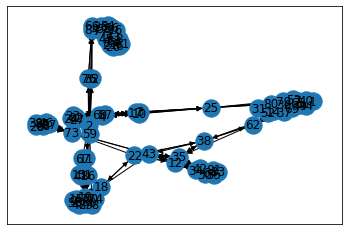

In [17]:
# networkx.draw(graph, with_labels=True, font_weight='bold')


nx.draw_networkx(g.to_networkx())
plt.show()

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph)
# plt.axis('off')
# nx.draw_networkx_nodes(graph,pos,node_color='g',alpha = 0.8)  # draws nodes
# nx.draw_networkx_edges(graph,pos,edge_color='b',alpha = 0.6)  # draws edges
# nx.draw_networkx_edge_labels(graph,pos,edge_labels = nx.get_edge_attributes(graph,'weight')) # edge lables
# nx.draw_networkx_labels(graph,pos) # node lables

In [18]:
from networkx.algorithms.dominating import dominating_set
g_nx = g.to_networkx()

# # to create our dataset, mimic missing measurements by finding some independent set of graph
# we will attempt to learn it!
remove = dominating_set(g_nx)

keep = np.asarray(list(set(np.arange(len(g_nx))) - remove), dtype=np.int64)
remove = np.asarray(list(remove), dtype=np.int64)
len(keep) + len(remove)

89

In [19]:
# First trail - try to learn altitude by proximity and average temp


class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(Net, self).__init__()
        # self.layer1 = GCNLayer(2, 2)
        # self.layer2 = GCNLayer(2, 1)
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, features):
        # x = F.leaky_relu(self.layer1(g, features))
        # x = self.layer2(g, x)
        # return x
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

net = Net(5, 5, 2)  # num_of_classes = temp, altitude
print(net)



Net(
  (conv1): GraphConv(in=5, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=2, normalization=both, activation=None)
)


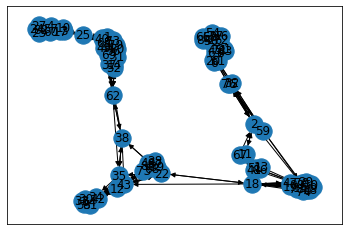

In [20]:
# https://docs.dgl.ai/tutorials/basics/3_pagerank.html
# https://docs.dgl.ai/tutorials/models/1_gnn/1_gcn.html
# g = dgl.DGLGraph()

# # https://docs.dgl.ai/generated/dgl.DGLGraph.from_networkx.html?highlight=from_networkx
# g.from_networkx(nx_graph=train_graph, edge_attrs=['distance'], node_attrs=['temp', 'height'])


embed = nn.Embedding(len(g), 5)  # |g| nodes with embedding dim equal to 5
g.ndata['feat'] = embed.weight

nx.draw_networkx(g.to_networkx())
plt.show()



In [25]:


labeled_nodes = torch.from_numpy(keep) # only half of the nodes are used for supervision

labeled_temp = g.nodes[labeled_nodes].data['temp']
labeled_height = g.nodes[labeled_nodes].data['height']
labels = torch.stack([labeled_temp, labeled_height], dim=1) # their labels are their height + temp

inputs = embed.weight

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.1)
all_logits = []
num_epochs = 300

for epoch in range(num_epochs):
    logits = net(g, inputs)

    # we save the logits for visualization later
    all_logits.append(logits.detach())

    # logp = F.log_softmax(logits, 1)
    logp = logits
    # we only compute loss for labeled nodes
    loss = F.mse_loss(logp[labeled_nodes], labels)
   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))



Epoch 0 | Loss: 26002.0801
Epoch 1 | Loss: 29745.0527
Epoch 2 | Loss: 27123.8223
Epoch 3 | Loss: 27603.1641
Epoch 4 | Loss: 27835.2578
Epoch 5 | Loss: 27057.3047
Epoch 6 | Loss: 26692.8242
Epoch 7 | Loss: 26929.5938
Epoch 8 | Loss: 27022.6465
Epoch 9 | Loss: 26732.1289
Epoch 10 | Loss: 26771.0898
Epoch 11 | Loss: 26531.9199
Epoch 12 | Loss: 26630.2188
Epoch 13 | Loss: 26494.9102
Epoch 14 | Loss: 26259.9355
Epoch 15 | Loss: 26149.6777
Epoch 16 | Loss: 26192.3027
Epoch 17 | Loss: 26230.0391
Epoch 18 | Loss: 26168.8711
Epoch 19 | Loss: 26075.0391
Epoch 20 | Loss: 26032.0312
Epoch 21 | Loss: 26015.7266
Epoch 22 | Loss: 25954.3809
Epoch 23 | Loss: 25862.5254
Epoch 24 | Loss: 25896.7539
Epoch 25 | Loss: 25896.9082
Epoch 26 | Loss: 25938.5918
Epoch 27 | Loss: 25887.8340
Epoch 28 | Loss: 25810.1152
Epoch 29 | Loss: 25797.5137
Epoch 30 | Loss: 25781.1172
Epoch 31 | Loss: 25809.2090
Epoch 32 | Loss: 25759.6230
Epoch 33 | Loss: 25733.0430
Epoch 34 | Loss: 25710.6328
Epoch 35 | Loss: 25703.5645
Ep

In [26]:

unlabeled_nodes = torch.from_numpy(remove)
unlabeled_temp = g.nodes[unlabeled_nodes].data['temp']
unlabeled_height = g.nodes[unlabeled_nodes].data['height']
unlabels = torch.stack([unlabeled_temp, unlabeled_height], dim=1).detach() # their labels are their height + temp

mean_err = torch.mean(torch.abs(logits[unlabeled_nodes][:, 0] - unlabels[:, 0] ))
print("mean temp error is {}".format(mean_err.data))

mean temp error is 3.1699740886688232
